# How to recover a known planet in Kepler data?

This tutorial will demonstrate the basic steps required to recover the signal of [Kepler-10b](https://en.wikipedia.org/wiki/Kepler-10b), the first rocky planet that was discovered by Kepler!

Let's start by downloading the pixel data for this target for one of Kepler's observing quarters:

In [1]:
import lightkurve as lk
tpf = lk.search_targetpixelfile("Kepler-10", author="Kepler", quarter=3, cadence="long").download()

Let's use the `plot` method to show the pixel data at one point in time (frame index 100). We'll also pass along a few plotting arguments.

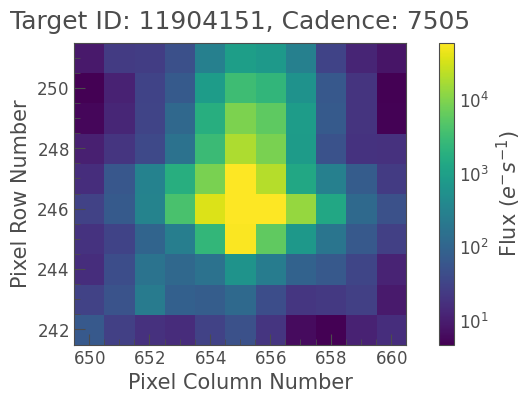

In [2]:
tpf.plot(frame=100, scale='log', show_colorbar=True);

The target pixel file appears to show one bright star with a core brightness of approximately 50,000 electrons/seconds.

Now, we will use the [to_lightcurve](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.to_lightcurve.html?highlight=to_lightcurve) method to create a simple aperture photometry lightcurve using the
mask defined by the pipeline which is stored in [tpf.pipeline_mask](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.pipeline_mask.html?highlight=pipeline_mask).

In [3]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

Let's take a look at the output lightcurve.

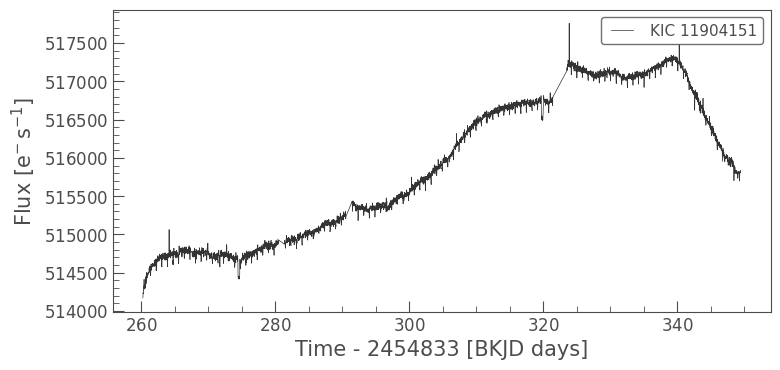

In [4]:
lc.plot();

Now let's use the [.flatten()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.flatten.html?highlight=flatten#lightkurve.LightCurve.flatten) method, which removes long-term variability that we are not interested in using a high-pass filter called *Savitzky-Golay*.

In [5]:
flat, trend = lc.flatten(window_length=301, return_trend=True)

Let's plot the trend estimated in red:

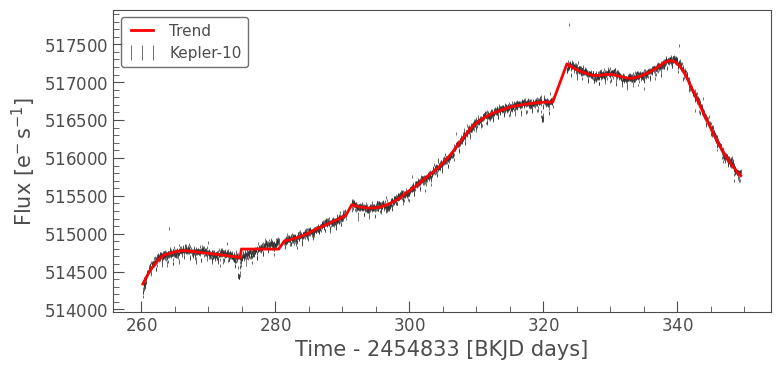

In [6]:
ax = lc.errorbar(label="Kepler-10")                   # plot() returns a matplotlib axes ...
trend.plot(ax=ax, color='red', lw=2, label='Trend');  # which we can pass to the next plot() to use the same axes

and the flat lightcurve:

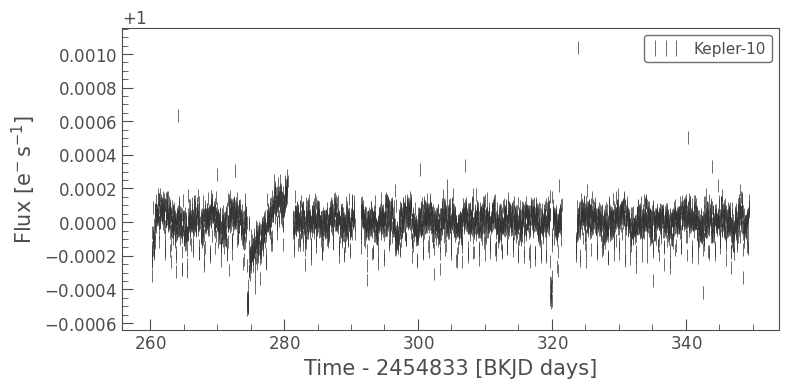

In [7]:
flat.errorbar(label="Kepler-10");

Now, let's run a period search function using the well-known Box-Least Squares algorithm (BLS), which was added to the [AstroPy package](http://docs.astropy.org) in version 3.1.

We will use the BLS algorithm to search a pre-defined grid of transit periods:

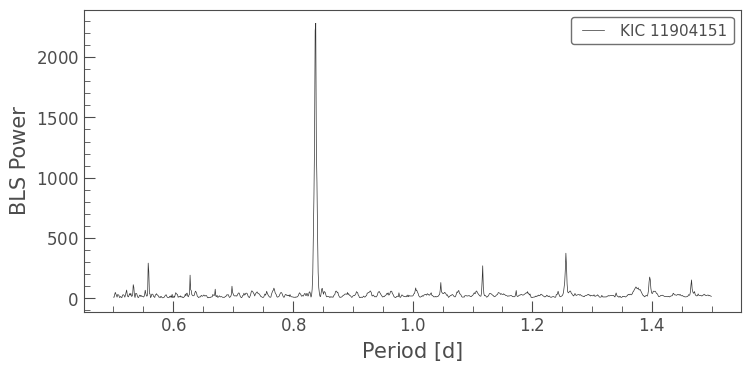

In [8]:
import numpy as np
periodogram = flat.to_periodogram(method="bls", period=np.arange(0.5, 1.5, 0.001))
periodogram.plot();

It looks like we found a strong signal with a periodicity near 0.8 days!

In [9]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))

Best fit period: 0.838 d


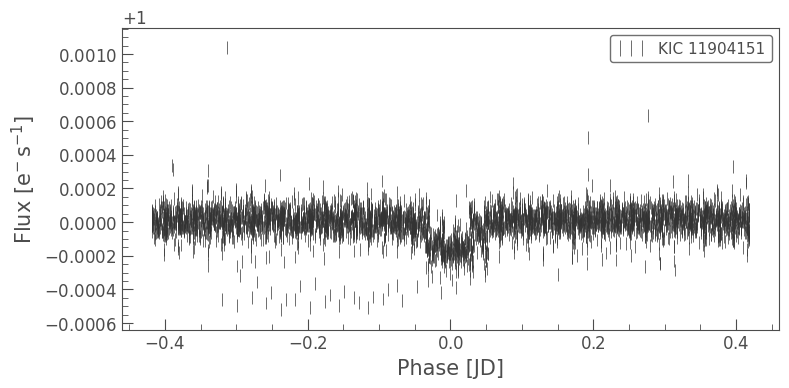

In [10]:
flat.fold(period=best_fit_period, epoch_time=periodogram.transit_time_at_max_power).errorbar();

We successfully recovered the planet!